# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [1]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

/Users/engineererjojo/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [3]:
df = df.astype(int)
# df.head(5)

In [4]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] > 0]
df = df.head(1000)

### Transformation Testing

DEP_DELAY skew score
4.820893338359548
DEP_DELAY_log skew score
0.25029895337632907
DEP_DELAY_BOXCOX skew score
0.027436832341569406


/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


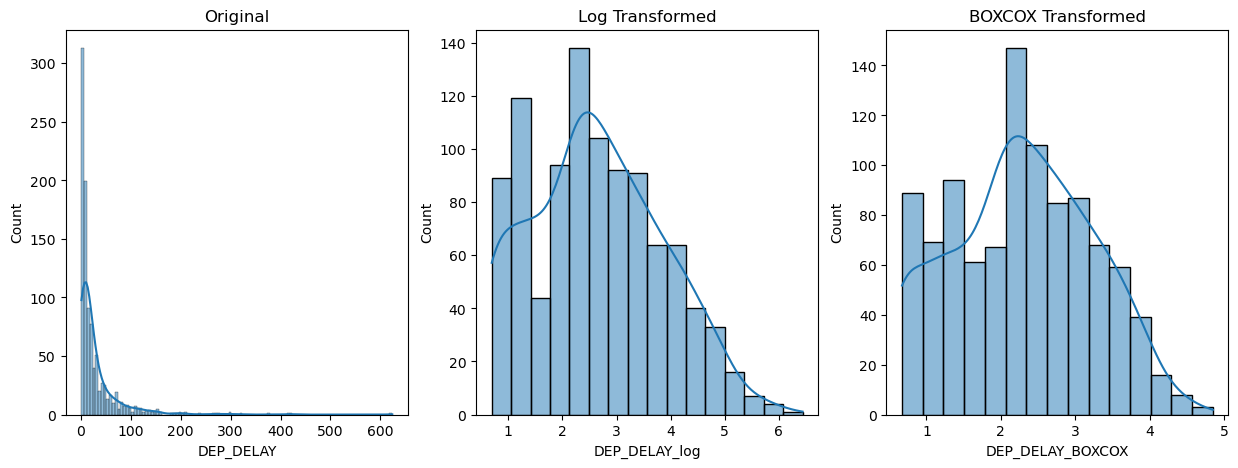

In [5]:
print('DEP_DELAY skew score')
print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
df['DEP_DELAY_sqrt'] = np.sqrt(df['DEP_DELAY_shifted']) # sqrt version

from scipy.stats import boxcox
df['DEP_DELAY_BOXCOX'], lambda_value = boxcox(df['DEP_DELAY_shifted'] + 1)  # Adding 1 to avoid issues with 0
# print(f' lambda value {lambda_}')

print('DEP_DELAY_log skew score')
print(df['DEP_DELAY_log'].skew())

print('DEP_DELAY_BOXCOX skew score')
print(df['DEP_DELAY_BOXCOX'].skew())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['DEP_DELAY'], kde=True, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(df['DEP_DELAY_log'], kde=True, ax=axes[1])
axes[1].set_title('Log Transformed')

sns.histplot(df['DEP_DELAY_BOXCOX'], kde=True, ax=axes[2])
axes[2].set_title('BOXCOX Transformed')

plt.show()

In [6]:
df['DEP_DELAY_BOXCOX']

2       3.142395
9       1.301006
14      3.805206
26      1.495255
30      1.780671
          ...   
3913    1.044581
3915    2.283104
3916    2.073672
3941    3.440988
3944    1.301006
Name: DEP_DELAY_BOXCOX, Length: 1000, dtype: float64

In [7]:
X = df.drop(columns=['DEP_DELAY_log', 'DEP_DELAY','DEP_DELAY_shifted', 'DEP_DELAY_sqrt', 'DEP_DELAY_BOXCOX']) #Dropping Transformation comparsion testing columns

# Using BoxCox Transformation
y = df['DEP_DELAY_BOXCOX'] # Target variable

y.head(3)

2     3.142395
9     1.301006
14    3.805206
Name: DEP_DELAY_BOXCOX, dtype: float64

### Feature Selection (Post Boxcox Transformation)

In [8]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_26816/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [9]:
k_num_features = 10

# Using 9 features only taking all F-Score above 60

In [10]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df_before = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df_before = feature_df_before.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df_before)

Selected Features:
                   Feature    F-Score
1                 DISTANCE  29.924300
0         CRS_ELAPSED_TIME  29.910261
5     OP_UNIQUE_CARRIER_DL  17.486525
3                  sch_dep  13.620715
2                 Pressure  13.604546
8                 DEST_PWM   8.999873
4     OP_UNIQUE_CARRIER_B6   8.065416
7                 DEST_BWI   8.044490
6                 DEST_BTV   7.176200
9  Condition_Partly Cloudy   7.172383


### BoxCox TransFormation

In [11]:
from scipy.stats import boxcox
X['sch_dep_boxcox'], lambda_value = boxcox(X['sch_dep'] + 1)  #Top1 Feature 
X['CRS_DEP_M_boxcox'], lambda_value = boxcox(X['CRS_DEP_M'] + 1) #Top2 Feature
X['OP_UNIQUE_CARRIER_DL_boxcox'], lambda_value = boxcox(X['OP_UNIQUE_CARRIER_DL'] + 1)  #Top3 Feature

X['CRS_ELAPSED_TIME_boxcox'], lambda_value = boxcox(X['CRS_ELAPSED_TIME'] + 1)  #Top4 Feature
X['DISTANCE_boxcox'], lambda_value = boxcox(X['DISTANCE'] + 1)  #Top5 Feature
X['OP_UNIQUE_CARRIER_B6_boxcox'], lambda_value = boxcox(X['OP_UNIQUE_CARRIER_B6'] + 1)  #Top6  Feature

X['OP_UNIQUE_CARRIER_MQ_boxcox'], lambda_value = boxcox(X['OP_UNIQUE_CARRIER_MQ'] + 1)  #Top7  Feature
X['Wind_Speed_boxcox'], lambda_value = boxcox(X['Wind Speed'] + 1) #Top8  Feature
X['Pressure_boxcox'], lambda_value = boxcox(X['Pressure'] + 1) #Top9  Feature



/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_26816/362596190.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['sch_dep_boxcox'], lambda_value = boxcox(X['sch_dep'] + 1)  #Top1 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_26816/362596190.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['CRS_DEP_M_boxcox'], lambda_value = boxcox(X['CRS_DEP_M'] + 1) #Top2 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_26816/362596190.py:4: PerformanceWarning: DataFrame is highly frag

In [12]:
# Drop columns that are log transform
X = X.drop(columns=[
            # 'sch_dep',
            # 'CRS_DEP_M',
            # 'OP_UNIQUE_CARRIER_DL',  
            # 'CRS_ELAPSED_TIME', 
            # 'DISTANCE',  
            # 'OP_UNIQUE_CARRIER_B6', 
            # 'OP_UNIQUE_CARRIER_MQ', 
            # 'Wind Speed',  
            # 'Pressure',
])

X = X.drop(columns=[
            'sch_dep_boxcox',
            'CRS_DEP_M_boxcox',
            'OP_UNIQUE_CARRIER_DL_boxcox',  
            'CRS_ELAPSED_TIME_boxcox', 
            'DISTANCE_boxcox',  
            'OP_UNIQUE_CARRIER_B6_boxcox', 
            'OP_UNIQUE_CARRIER_MQ_boxcox', 
            'Wind_Speed_boxcox',  
            'Pressure_boxcox',
])

### Comparsing F-Score of Boxcox-Feature 
Check Feature Selection F-Score Again

In [13]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features - 8 # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features (New Comparsion):")
print(feature_df)

Selected Features (New Comparsion):
            Feature    F-Score
1          DISTANCE  29.924300
0  CRS_ELAPSED_TIME  29.910261


### Split Training and Test Data 80:20

In [14]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 27)

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Diff Regression

In [16]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# from sklearn.tree import DecisionTreeRegressor
# regressor = DecisionTreeRegressor(random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.svm import SVR
# regressor = SVR(kernel = 'rbf')
# regressor.fit(X_train, y_train)

### KNN Model

In [17]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=15, metric='manhattan', weights='distance')
# regressor = KNeighborsRegressor(n_neighbors=19, metric='euclidean')

regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=15, weights='distance')

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [18]:
import numpy as np
from scipy import stats

# Assuming you have a lambda value from the Box-Cox transformation:
# If you performed the Box-Cox transformation like this:
y_train_transformed, lambda_value = stats.boxcox(y_train)

# And you transformed y_test similarly (or using the same lambda):
y_test_transformed = stats.boxcox(y_test, lmbda=lambda_value)

# After training, your model predicts on the transformed scale:
y_pred_transformed = regressor.predict(X_test)

# To reverse the Box-Cox transformation and convert back to the original scale:
def inverse_boxcox(y, lmbda):
    if lmbda != 0:
        return np.power(y * lmbda + 1, 1 / lmbda)
    else:
        return np.exp(y)

# Reverse transformation for predictions:
y_pred_original = inverse_boxcox(y_pred_transformed, lambda_value)

# Reverse transformation for y_test if needed:
y_test_original = inverse_boxcox(y_test_transformed, lambda_value)

# Now you can compare y_pred_original with y_test_original using your evaluation metrics.


In [19]:
print(y_pred_transformed)
print(y_pred_original)

[1.8494448  4.30066239 2.04858238 1.04458054 1.95565719 2.10603098
 2.82502683 0.67137152 2.66371762 2.18618402 2.95483459 2.54782365
 2.10633018 1.69180635 2.67059935 2.75439905 2.00962164 2.22318102
 1.75415092 2.39273173 2.59843052 2.89289687 2.53944282 2.81442115
 1.43579443 0.67137152 1.30100633 2.78948311 2.36283321 1.7955555
 2.33712874 2.91767827 2.78979682 1.84879937 3.68733008 2.22260053
 2.33712874 2.59843052 2.15270066 2.29319734 1.92273111 2.7331059
 2.09094274 2.22694931 2.67059935 2.54782365 2.0451725  1.93197953
 2.42130192 2.4517124  0.67137152 2.36283321 2.49351212 1.55356848
 1.09112806 3.0225949  2.94157312 2.90604142 2.89289687 2.27277504
 2.15270066 2.40168011 2.8001928  1.85889229 2.33712874 1.90859267
 2.06923355 1.68874033 2.45858701 3.04717998 2.07367154 2.35592376
 1.41849395 2.42130192 2.19737658 1.41849395 2.5843941  2.29507669
 2.17202554 1.7455556  0.67137152 3.02125843 2.66553918 3.22783719
 1.91278872 0.67137152 1.7806713  3.78492584 2.0548256  3.022594

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
# r2 = r2_score(y_test_original, y_pred_original)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 2.78
Mean Absolute Error (MAE): 1.38


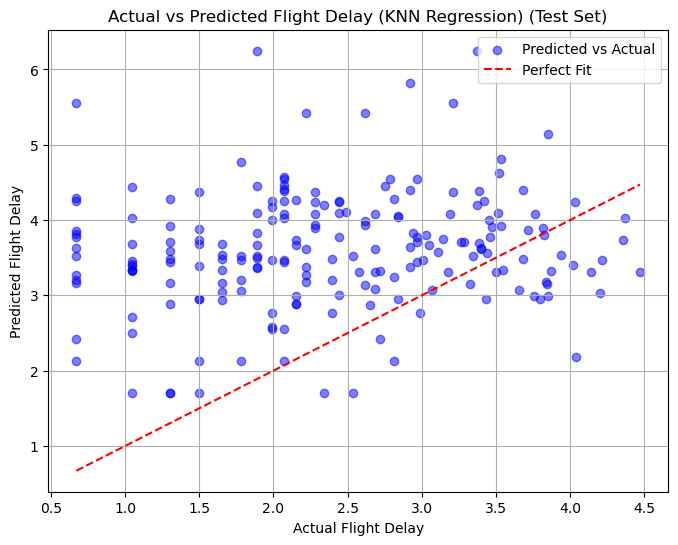

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression) (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_neighbors': range(3, 21, 2)}
# grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
# grid.fit(X_train, y_train)
# print("Best k:", grid.best_params_)